In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.transforms import v2 as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import math

Created output folder: ./clean_train_data
Processing 691 images...


100%|██████████| 691/691 [00:20<00:00, 33.24it/s]



Processing Complete. Clean data saved to './clean_train_data'

Visualization of Requested Examples:


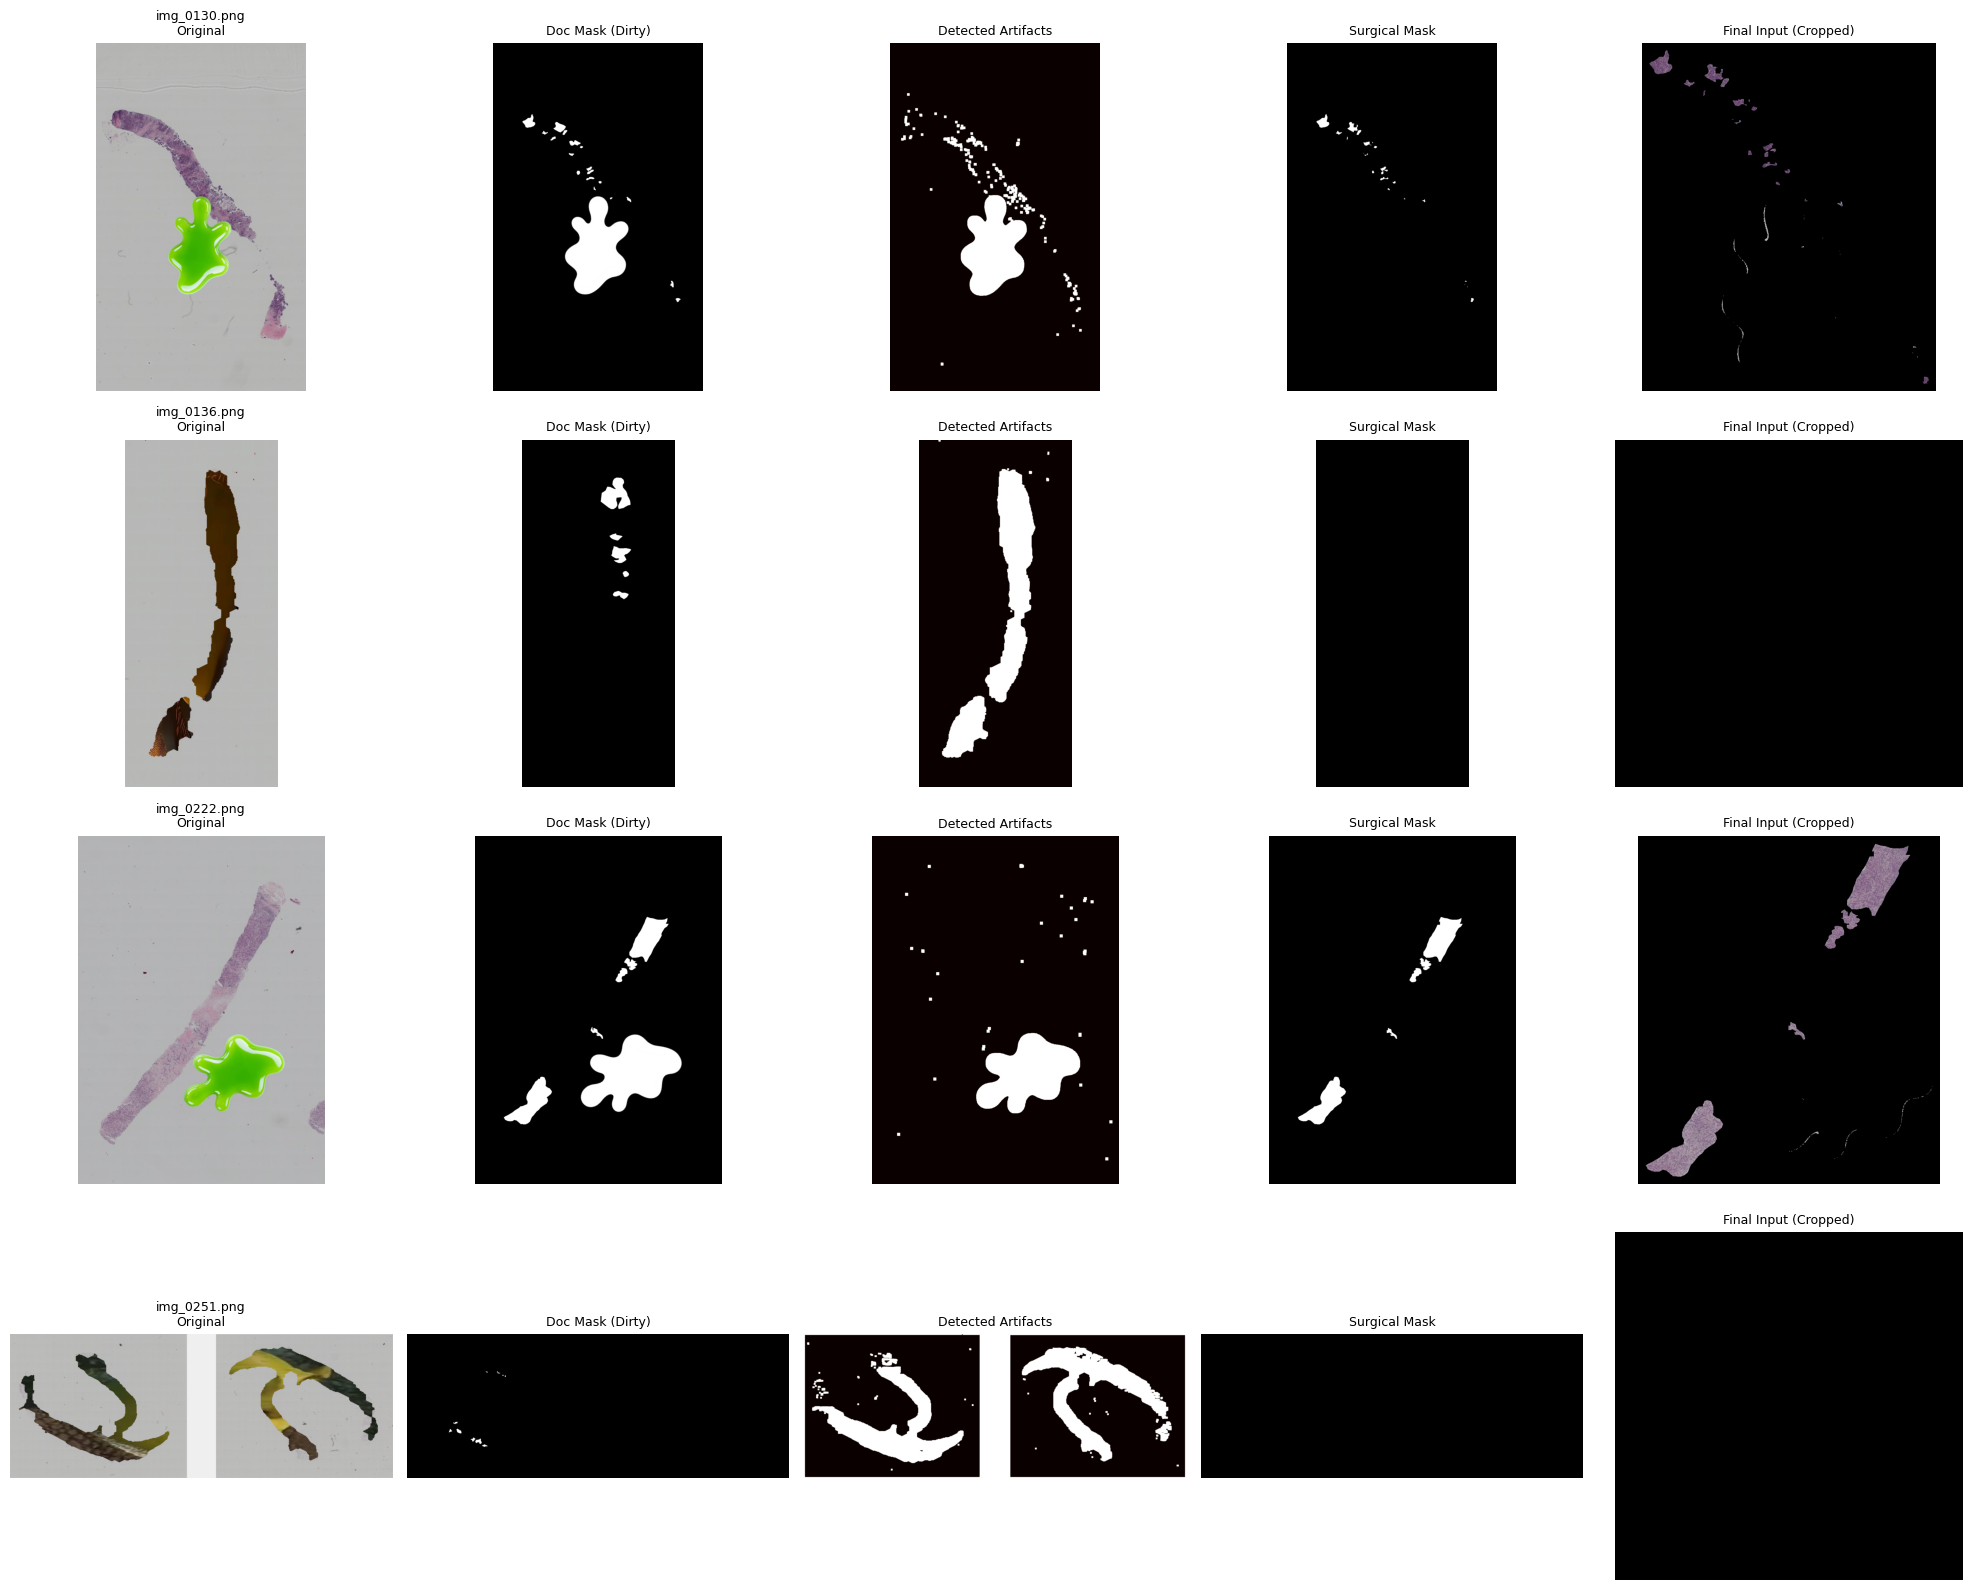

In [ ]:
# --- CONFIGURATION ---
BASE_DIR = '../data' 
TRAIN_DIR = os.path.join(BASE_DIR, 'train_data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'clean_train_data')
CSV_PATH = os.path.join(BASE_DIR, 'train_labels.csv')

# 1. WIDENED Artifact Colors (More Aggressive)
# Green: Widened Hue (25-95) to catch Lime & Teal. Lowered Sat/Val (40) for dark/dull green.
LOWER_GREEN = np.array([25, 40, 40]); UPPER_GREEN = np.array([95, 255, 255])

# Orange: Widened Hue (5-35) to catch Red-Orange & Yellow. Lowered Sat/Val (50) for faint marker.
LOWER_ORANGE = np.array([5, 50, 50]); UPPER_ORANGE = np.array([35, 255, 255])

# White: Kept same (Standard for bright centers)
LOWER_WHITE = np.array([0, 0, 200]); UPPER_WHITE = np.array([180, 30, 255])

LOWER_BROWN = np.array([0, 60, 20]); UPPER_BROWN = np.array([25, 255, 150])

# 2. Dilation (To eat up the jagged edges of the splash)
DILATION_KERNEL = np.ones((5, 5), np.uint8)
DILATION_ITERS = 3

# 3. Examples to Visualize
EXAMPLES_TO_SHOW = ['img_0130', 'img_0136', 'img_0222', 'img_0251']
# ---------------------

# Setup Output Directory
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR) # Clean start
os.makedirs(OUTPUT_DIR)
print(f"Created output folder: {OUTPUT_DIR}")

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"Processing {len(df)} images...")
    
    saved_examples = [] 

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        col_name = 'sample_index' if 'sample_index' in df.columns else 'image_id'
        img_name = row[col_name]
        
        # Paths
        img_path = os.path.join(TRAIN_DIR, img_name)
        mask_name_guess = img_name.replace("img_", "mask_")
        mask_path = os.path.join(TRAIN_DIR, mask_name_guess)
        
        # Load
        img = cv2.imread(img_path)
        if img is None: continue
        
        # Load Mask
        if os.path.exists(mask_path):
            original_mask = cv2.imread(mask_path, 0)
        else:
            original_mask = np.full(img.shape[:2], 255, dtype=np.uint8)

        # --- A. DETECT ARTIFACTS ---
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        m_green = cv2.inRange(hsv, LOWER_GREEN, UPPER_GREEN)
        m_orange = cv2.inRange(hsv, LOWER_ORANGE, UPPER_ORANGE)
        m_white = cv2.inRange(hsv, LOWER_WHITE, UPPER_WHITE)
        m_brown = cv2.inRange(hsv, LOWER_BROWN, UPPER_BROWN)

        
        bad_pixels = cv2.bitwise_or(m_green, m_orange)
        bad_pixels = cv2.bitwise_or(bad_pixels, m_white)
        bad_pixels = cv2.bitwise_or(bad_pixels, m_brown)

        
        # Expand artifact mask (Dilation)
        bad_pixels_expanded = cv2.dilate(bad_pixels, DILATION_KERNEL, iterations=DILATION_ITERS)
        
        # --- B. SURGICAL CORRECTION ---
        # "Keep the mask ONLY where it is NOT bad"
        clean_mask = cv2.bitwise_and(original_mask, cv2.bitwise_not(bad_pixels_expanded))
        
        # --- C. CROP TO ROI ---
        y, x = np.where(clean_mask > 0)
        
        if len(y) > 0:
            pad = 20
            y_min, y_max = max(0, y.min()-pad), min(img.shape[0], y.max()+pad)
            x_min, x_max = max(0, x.min()-pad), min(img.shape[1], x.max()+pad)
            
            # Apply Mask & Crop
            masked_img = cv2.bitwise_and(img, img, mask=clean_mask)
            final_img = masked_img[y_min:y_max, x_min:x_max]
            final_mask = clean_mask[y_min:y_max, x_min:x_max]
        else:
            # If mask is empty (was 100% Shrek), save empty placeholder (will filter later if needed)
            final_img = np.zeros((100, 100, 3), dtype=np.uint8)
            final_mask = np.zeros((100, 100), dtype=np.uint8)

        # --- D. SAVE ---
        cv2.imwrite(os.path.join(OUTPUT_DIR, img_name), final_img)
        
        # --- E. CAPTURE FOR VISUALIZATION ---
        base_name = os.path.splitext(img_name)[0]
        if any(ex in base_name for ex in EXAMPLES_TO_SHOW):
            saved_examples.append({
                'name': img_name,
                'orig': cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                'orig_mask': original_mask,
                'bad_mask': bad_pixels_expanded,
                'clean_mask': clean_mask,
                'final': cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            })

    print(f"\nProcessing Complete. Clean data saved to '{OUTPUT_DIR}'")

    # --- 3. VISUALIZE EXAMPLES (5 Columns) ---
    if len(saved_examples) > 0:
        print("\nVisualization of Requested Examples:")
        fig, axes = plt.subplots(len(saved_examples), 5, figsize=(20, 4 * len(saved_examples)))
        if len(saved_examples) == 1: axes = np.array([axes])
        
        for i, item in enumerate(saved_examples):
            # 1. Original Image
            axes[i, 0].imshow(item['orig'])
            axes[i, 0].set_title(f"{item['name']}\nOriginal", fontsize=9)
            
            # 2. Original Mask
            axes[i, 1].imshow(item['orig_mask'], cmap='gray')
            axes[i, 1].set_title("Doc Mask (Dirty)", fontsize=9)
            
            # 3. Detected Junk
            axes[i, 2].imshow(item['bad_mask'], cmap='hot')
            axes[i, 2].set_title("Detected Artifacts", fontsize=9)
            
            # 4. Clean Mask
            axes[i, 3].imshow(item['clean_mask'], cmap='gray')
            axes[i, 3].set_title("Surgical Mask", fontsize=9)
            
            # 5. Final Result
            axes[i, 4].imshow(item['final'])
            axes[i, 4].set_title("Final Input (Cropped)", fontsize=9)
            
            for ax in axes[i]: ax.axis('off')
            
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: None of the requested examples {EXAMPLES_TO_SHOW} were found.")

else:
    print(f"Error: {CSV_PATH} not found.")

In [27]:
# Configuration
OUTPUT_DIR = 'clean_train_data'

if os.path.exists(OUTPUT_DIR):
    # Count only image files
    all_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.png', '.jpg', '.tif'))]
    print(f"Total images in '{OUTPUT_DIR}': {len(all_files)}")
else:
    print(f"Error: Directory '{OUTPUT_DIR}' does not exist. Did you run the Factory Script?")

Total images in 'clean_train_data': 691


In [28]:
# --- CONFIGURATION ---
# Re-define ranges to check against
LOWER_GREEN = np.array([35, 50, 50]); UPPER_GREEN = np.array([85, 255, 255])
LOWER_ORANGE = np.array([10, 80, 80]); UPPER_ORANGE = np.array([30, 255, 255])
LOWER_BROWN = np.array([0, 60, 20]); UPPER_BROWN = np.array([25, 255, 150])
LOWER_GREY = np.array([0, 0, 50]); UPPER_GREY = np.array([180, 40, 180])

black_images = []
colored_artifacts = []

print("🔍 Auditing cleaned dataset for empty images and leftovers...")

image_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.png', '.jpg'))]

for img_name in tqdm(image_files):
    img_path = os.path.join(OUTPUT_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None: continue

    # 1. CHECK IF IMAGE IS EMPTY (Black)
    # Convert to grayscale and count non-zero pixels
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    non_zero = cv2.countNonZero(gray)
    total_pixels = img.shape[0] * img.shape[1]
    
    # If less than 1% of the image has content, it is "Black"
    if (non_zero / total_pixels) < 0.001:
        black_images.append(img_name)
        continue # Skip color check if it's black

    # 2. CHECK FOR LEFTOVER COLORS
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Combine all "Bad" masks
    m_g = cv2.inRange(hsv, LOWER_GREEN, UPPER_GREEN)
    m_o = cv2.inRange(hsv, LOWER_ORANGE, UPPER_ORANGE)
    m_b = cv2.inRange(hsv, LOWER_BROWN, UPPER_BROWN)
    m_gr = cv2.inRange(hsv, LOWER_GREY, UPPER_GREY)
    
    combined_junk = cv2.bitwise_or(m_g, m_o)
    combined_junk = cv2.bitwise_or(combined_junk, m_b)
    combined_junk = cv2.bitwise_or(combined_junk, m_gr)
    
    # If meaningful amount of junk remains (e.g. > 500 pixels)
    if cv2.countNonZero(combined_junk) > 500:
        colored_artifacts.append(img_name)

print(f"\n⚫ Found {len(black_images)} nearly empty/black images (To be deleted).")
print(f"🎨 Found {len(colored_artifacts)} images with potential artifacts left.")

if len(black_images) > 0:
    print(f"Sample Black Image: {black_images[0]}")

🔍 Auditing cleaned dataset for empty images and leftovers...


100%|██████████| 691/691 [00:02<00:00, 268.56it/s]


⚫ Found 39 nearly empty/black images (To be deleted).
🎨 Found 428 images with potential artifacts left.
Sample Black Image: img_0558.png


In [29]:
CSV_CLEAN_PATH = 'clean_train_labels.csv'

if len(black_images) > 0:
    print(f"Removing {len(black_images)} empty images from disk and CSV...")
    
    # 1. Delete Files
    for img_name in black_images:
        path = os.path.join(OUTPUT_DIR, img_name)
        if os.path.exists(path):
            os.remove(path)
            
    # 2. Update CSV
    if os.path.exists(CSV_CLEAN_PATH):
        df = pd.read_csv(CSV_CLEAN_PATH)
        print(f"Original Label Count: {len(df)}")
        
        # Handle column naming
        col_name = 'sample_index' if 'sample_index' in df.columns else 'image_id'
        
        # Filter: Keep rows where image IS NOT in the black_images list
        df_final = df[~df[col_name].isin(black_images)]
        
        # Save
        df_final.to_csv(CSV_CLEAN_PATH, index=False)
        print(f"New Label Count:      {len(df_final)}")
        print("Cleaned CSV updated successfully.")
    else:
        print("CSV file not found to update.")
else:
    print("No black images found. Dataset is healthy!")

Removing 39 empty images from disk and CSV...
Original Label Count: 645
New Label Count:      645
Cleaned CSV updated successfully.


In [30]:
# --- CONFIGURATION ---
# Re-define ranges to check against
LOWER_GREEN = np.array([35, 50, 50]); UPPER_GREEN = np.array([85, 255, 255])
LOWER_ORANGE = np.array([10, 80, 80]); UPPER_ORANGE = np.array([30, 255, 255])
LOWER_BROWN = np.array([0, 60, 20]); UPPER_BROWN = np.array([25, 255, 150])
LOWER_GREY = np.array([0, 0, 50]); UPPER_GREY = np.array([180, 40, 180])

black_images = []
colored_artifacts = []

print("🔍 Auditing cleaned dataset for empty images and leftovers...")

image_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.png', '.jpg'))]

for img_name in tqdm(image_files):
    img_path = os.path.join(OUTPUT_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None: continue

    # 1. CHECK IF IMAGE IS EMPTY (Black)
    # Convert to grayscale and count non-zero pixels
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    non_zero = cv2.countNonZero(gray)
    total_pixels = img.shape[0] * img.shape[1]
    
    # If less than 1% of the image has content, it is "Black"
    if (non_zero / total_pixels) < 0.001:
        black_images.append(img_name)
        continue # Skip color check if it's black

    # 2. CHECK FOR LEFTOVER COLORS
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Combine all "Bad" masks
    m_g = cv2.inRange(hsv, LOWER_GREEN, UPPER_GREEN)
    m_o = cv2.inRange(hsv, LOWER_ORANGE, UPPER_ORANGE)
    m_b = cv2.inRange(hsv, LOWER_BROWN, UPPER_BROWN)
    m_gr = cv2.inRange(hsv, LOWER_GREY, UPPER_GREY)
    
    combined_junk = cv2.bitwise_or(m_g, m_o)
    combined_junk = cv2.bitwise_or(combined_junk, m_b)
    combined_junk = cv2.bitwise_or(combined_junk, m_gr)
    
    # If meaningful amount of junk remains (e.g. > 500 pixels)
    if cv2.countNonZero(combined_junk) > 500:
        colored_artifacts.append(img_name)

print(f"\nFound {len(black_images)} nearly empty/black images (To be deleted).")
print(f"Found {len(colored_artifacts)} images with potential artifacts left.")

if len(black_images) > 0:
    print(f"Sample Black Image: {black_images[0]}")

🔍 Auditing cleaned dataset for empty images and leftovers...


100%|██████████| 652/652 [00:02<00:00, 277.84it/s]


Found 0 nearly empty/black images (To be deleted).
Found 428 images with potential artifacts left.


Starting Aggressive Scan (Broad Green/Yellow)...


100%|██████████| 652/652 [00:02<00:00, 315.62it/s]



Found 7 suspects with the broad filter.


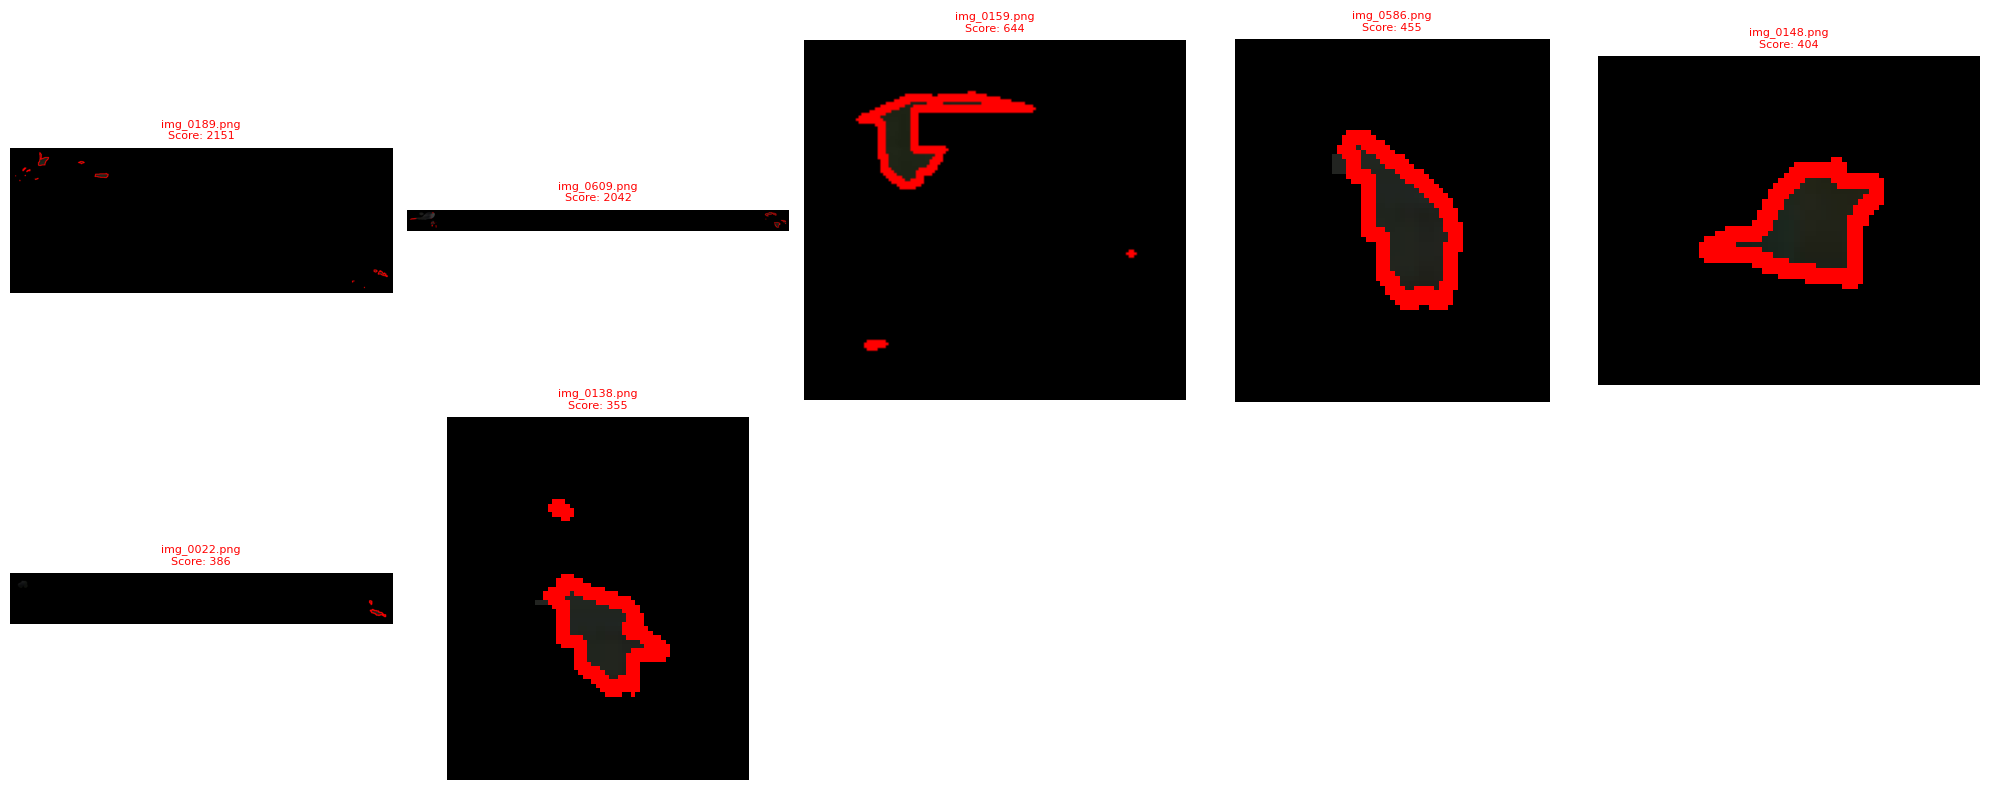


Copy this variable name: broad_suspects


In [31]:
# --- CONFIGURATION ---
OUTPUT_DIR = 'clean_train_data'
NUM_TO_SHOW = 50
PIXEL_THRESHOLD = 200 # Lowered threshold to catch even small specks
# ---------------------

# 1. BROADER Color Definitions (Aggressive Mode)
# Green: Standard is 35-85. We widen to 20-100 to catch Lime & Teal.
# We also lower Saturation (S) to 30 to catch "dull" greens.
LOWER_GREEN = np.array([20, 30, 30])
UPPER_GREEN = np.array([100, 255, 255])

# Orange/Yellow: Standard is 10-30. We widen to 5-45.
# This catches Red-Orange markers and Yellow highlighters.
LOWER_ORANGE = np.array([5, 50, 50])
UPPER_ORANGE = np.array([45, 255, 255])

print("Starting Aggressive Scan (Broad Green/Yellow)...")

suspects = []

if os.path.exists(OUTPUT_DIR):
    image_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(('.png', '.jpg'))]
    
    for img_name in tqdm(image_files):
        img_path = os.path.join(OUTPUT_DIR, img_name)
        img = cv2.imread(img_path)
        if img is None: continue
        
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # 2. Create Masks
        mask_g = cv2.inRange(hsv, LOWER_GREEN, UPPER_GREEN)
        mask_o = cv2.inRange(hsv, LOWER_ORANGE, UPPER_ORANGE)
        
        # Combine
        junk_mask = cv2.bitwise_or(mask_g, mask_o)
        
        # 3. Count Pixels
        count = cv2.countNonZero(junk_mask)
        
        if count > PIXEL_THRESHOLD:
            suspects.append({
                'name': img_name,
                'count': count,
                'path': img_path,
                'mask': junk_mask
            })

    print(f"\nFound {len(suspects)} suspects with the broad filter.")

    # --- VISUALIZATION ---
    if len(suspects) > 0:
        # Sort by worst offenders
        suspects.sort(key=lambda x: x['count'], reverse=True)
        top_suspects = suspects[:NUM_TO_SHOW]
        
        rows = (len(top_suspects) + 4) // 5
        fig, axes = plt.subplots(rows, 5, figsize=(20, 4*rows))
        axes = axes.flatten()
        
        for i, item in enumerate(top_suspects):
            img = cv2.imread(item['path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw contours of the junk to show WHAT we detected
            contours, _ = cv2.findContours(item['mask'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(img, contours, -1, (255, 0, 0), 2) # Red outline
            
            axes[i].imshow(img)
            axes[i].set_title(f"{item['name']}\nScore: {item['count']}", fontsize=8, color='red')
            axes[i].axis('off')
            
        for j in range(i+1, len(axes)): axes[j].axis('off')
        plt.tight_layout()
        plt.show()
        
        # Save list for next step
        broad_suspects = [x['name'] for x in suspects]
        print(f"\nCopy this variable name: broad_suspects")
    else:
        print("No Green/Yellow artifacts found even with broad ranges.")
else:
    print(f"Error: {OUTPUT_DIR} not found.")

In [32]:
if 'broad_suspects' in locals() and len(broad_suspects) > 0:
    print(f"Deleting {len(broad_suspects)} confirmed artifacts...")
    
    # 1. Remove from Disk
    for fname in broad_suspects:
        p = os.path.join(OUTPUT_DIR, fname)
        if os.path.exists(p): os.remove(p)
    
    # 2. Update CSV
    CSV_CLEAN_PATH = 'clean_train_labels.csv'
    if os.path.exists(CSV_CLEAN_PATH):
        df = pd.read_csv(CSV_CLEAN_PATH)
        col = 'sample_index' if 'sample_index' in df.columns else 'image_id'
        
        # Keep only rows NOT in the suspect list
        df_clean = df[~df[col].isin(broad_suspects)]
        df_clean.to_csv(CSV_CLEAN_PATH, index=False)
        
        print(f"Done. CSV updated: {len(df)} -> {len(df_clean)} rows.")
    else:
        print("CSV file not found. Images deleted, but CSV not updated.")
else:
    print("No suspects to delete.")

Deleting 7 confirmed artifacts...
Done. CSV updated: 645 -> 645 rows.


In [33]:
# --- CONFIGURATION ---
BASE_DIR = '.' 
CLEAN_DIR = os.path.join(BASE_DIR, 'clean_train_data')
ORIGINAL_CSV = os.path.join(BASE_DIR, 'train_labels.csv')
NEW_CSV = os.path.join(BASE_DIR, 'clean_train_labels.csv')
# ---------------------

if os.path.exists(CLEAN_DIR) and os.path.exists(ORIGINAL_CSV):
    print(f"Scanning '{CLEAN_DIR}'...")
    
    # 1. Get list of files that actually exist
    valid_files = [f for f in os.listdir(CLEAN_DIR) if f.endswith(('.png', '.jpg', '.tif'))]
    print(f"Found {len(valid_files)} cleaned images.")
    
    # 2. Load Original CSV
    df = pd.read_csv(ORIGINAL_CSV)
    
    # 3. Handle Column Names (sample_index vs image_id)
    col_name = 'sample_index' if 'sample_index' in df.columns else 'image_id'
    
    # 4. Filter Dataframe
    # Keep only rows where the filename is in our valid_files list
    df_clean = df[df[col_name].isin(valid_files)].reset_index(drop=True)
    
    # 5. Save
    df_clean.to_csv(NEW_CSV, index=False)
    
    print("-" * 40)
    print(f"Original Labels: {len(df)}")
    print(f"Cleaned Labels:  {len(df_clean)}")
    print(f"Saved to:      {NEW_CSV}")
    print("-" * 40)
    
else:
    print("Error: Could not find 'clean_train_data' folder or original CSV.")

Scanning './clean_train_data'...
Found 645 cleaned images.
----------------------------------------
Original Labels: 691
Cleaned Labels:  645
Saved to:      ./clean_train_labels.csv
----------------------------------------


In [34]:
# --- CONFIGURATION ---
BASE_DIR = '.'
CLEAN_IMG_DIR = os.path.join(BASE_DIR, 'clean_train_data')
CLEAN_CSV_PATH = os.path.join(BASE_DIR, 'clean_train_labels.csv')

BATCH_SIZE = 16  # Safe for local GPU. Increase to 32 if you have >8GB VRAM.
IMG_SIZE = 384   # Native resolution for EfficientNetV2-S
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"✅ Active Device: {DEVICE}")

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

✅ Active Device: mps


In [35]:
# 1. Load Clean Data
if not os.path.exists(CLEAN_CSV_PATH):
    raise FileNotFoundError("Run the cleaning script first to generate clean_train_labels.csv!")

df = pd.read_csv(CLEAN_CSV_PATH)

# 2. Stratified Split (80/20)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

# 3. Calculate Sampler Weights (Fixes Imbalance)
class_counts = train_df['label'].value_counts()
weight_per_class = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [weight_per_class[label] for label in train_df['label']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_df), replacement=True)

print(f"Training Samples: {len(train_df)} | Validation Samples: {len(val_df)}")
print("Sampler weights calculated.")

Training Samples: 516 | Validation Samples: 129
Sampler weights calculated.


In [ ]:
# --- INSTALL LION IF MISSING ---
try:
    from lion_pytorch import Lion
    print("Lion Optimizer imported.")
except ImportError:
    print("Lion not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "lion-pytorch"])
    from lion_pytorch import Lion
    print("Lion installed and imported.")

# --- CONFIGURATION ---
BASE_DIR = '.' 
CLEAN_IMG_DIR = os.path.join(BASE_DIR, 'clean_train_data')
CLEAN_CSV_PATH = os.path.join(BASE_DIR, 'clean_train_labels.csv')

BATCH_SIZE = 16  # Safe for local GPU
IMG_SIZE = 384   # EfficientNetV2 resolution
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Training on Device: {DEVICE}")

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

Lion Optimizer imported.
Training on Device: cpu


In [38]:
# 1. Load Data
if not os.path.exists(CLEAN_CSV_PATH):
    raise FileNotFoundError("Run the cleaning script first to generate clean_train_labels.csv!")

df = pd.read_csv(CLEAN_CSV_PATH)

# 2. Stratified Split (80/20)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

# 3. Calculate Sampler Weights (Fixes Imbalance)
class_counts = train_df['label'].value_counts()
weight_per_class = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [weight_per_class[label] for label in train_df['label']]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_df), replacement=True)

print(f"Training Samples: {len(train_df)} | Validation Samples: {len(val_df)}")
print("Sampler weights calculated.")

Training Samples: 516 | Validation Samples: 129
Sampler weights calculated.


In [39]:
class CleanDoctogreDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {"Luminal A": 0, "Luminal B": 1, "HER2(+)": 2, "Triple negative": 3}

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        col = 'sample_index' if 'sample_index' in self.df.columns else 'image_id'
        img_name = row[col]
        label = self.label_map[row['label']]
        
        # Direct Load
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE)) # Fallback
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("Dataset class defined.")

Dataset class defined.


In [40]:
# 1. Training Transforms (Automated Chaos)
train_tfm = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    
    # --- AUTOMATED AUGMENTATION ---
    transforms.RandAugment(num_ops=2, magnitude=9), 
    
    # Geometric
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    
    # Robustness
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
    
    # Format
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Validation Transforms (Clean)
val_tfm = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Loaders
# num_workers=0 is required for local execution on Windows/Mac to avoid errors
train_ds = CleanDoctogreDataset(train_df, CLEAN_IMG_DIR, transform=train_tfm)
val_ds = CleanDoctogreDataset(val_df, CLEAN_IMG_DIR, transform=val_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("DataLoaders Ready.")

DataLoaders Ready.


In [42]:
# --- 5. MODEL & OPTIMIZER (THE LION) ---
print("Loading EfficientNetV2-S...")
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 🔥 LION OPTIMIZER
print("Initializing Lion Optimizer (LR=3e-5)...")
optimizer = Lion(model.parameters(), lr=3e-5, weight_decay=1e-2)

scheduler = CosineAnnealingLR(optimizer, T_max=10)

# FIX: Only enable Scaler if we are actually on an NVIDIA GPU
use_amp = (DEVICE == 'cuda')
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

print(f"Model Ready. Mixed Precision Enabled: {use_amp}")

Loading EfficientNetV2-S...
Initializing Lion Optimizer (LR=3e-5)...
Model Ready. Mixed Precision Enabled: False


In [ ]:
# --- CONFIGURATION ---
WARMUP_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
# ---------------------

# 1. SETUP MODEL (Transfer Learning)
print("Loading EfficientNetV2-S...")
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Freeze Backbone (Stage 1)
for param in model.features.parameters():
    param.requires_grad = False

# Replace Head
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)
model = model.to(DEVICE)

# Loss Function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Helper Function
def run_epoch(loader, optimizer, is_train=True):
    model.train() if is_train else model.eval()
    all_preds, all_targets = [], []
    loss_sum = 0
    
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, desc="Train" if is_train else "Val", leave=False)
        for x, y in pbar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            if is_train: optimizer.zero_grad()
            
            with torch.amp.autocast('cuda' if DEVICE=='cuda' else 'cpu', enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y)
            
            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
            loss_sum += loss.item()
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
    return loss_sum/len(loader), f1_score(all_targets, all_preds, average='weighted')

Loading EfficientNetV2-S...


In [47]:
# --- STAGE 1: WARMUP (Lion) ---
print(f"\nSTARTING STAGE 1: WARMUP ({WARMUP_EPOCHS} Epochs) - Lion Optimizer")

# Optimizer: Lion with higher LR for head training
# (AdamW would be 1e-3, so Lion is 1e-4)
optimizer_warmup = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for epoch in range(WARMUP_EPOCHS):
    t_loss, t_f1 = run_epoch(train_loader, optimizer_warmup, is_train=True)
    v_loss, v_f1 = run_epoch(val_loader, optimizer_warmup, is_train=False)
    
    print(f"Warmup {epoch+1}: Train Loss {t_loss:.3f} | Val F1 {v_f1:.4f}")
    
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['val_f1'].append(v_f1)


STARTING STAGE 1: WARMUP (5 Epochs) - Lion Optimizer


Warmup 1: Train Loss 1.403 | Val F1 0.2289


Warmup 2: Train Loss 1.385 | Val F1 0.1971


Warmup 3: Train Loss 1.373 | Val F1 0.2042


Warmup 4: Train Loss 1.366 | Val F1 0.1871


Warmup 5: Train Loss 1.353 | Val F1 0.2254


In [48]:
# --- STAGE 2: FINE-TUNING (Lion) ---
print(f"\nSTARTING STAGE 2: FINE-TUNING ({FINE_TUNE_EPOCHS} Epochs) - Full Unfreeze")

# Unfreeze Everything
for param in model.parameters():
    param.requires_grad = True

# Optimizer: Lion with very low LR for fine-tuning
# (AdamW would be 5e-5, so Lion is 1e-5)
optimizer_ft = Lion(model.parameters(), lr=1e-5, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer_ft, T_max=FINE_TUNE_EPOCHS)

best_f1 = 0

for epoch in range(FINE_TUNE_EPOCHS):
    t_loss, t_f1 = run_epoch(train_loader, optimizer_ft, is_train=True)
    v_loss, v_f1 = run_epoch(val_loader, optimizer_ft, is_train=False)
    scheduler.step()
    
    # Store Stats
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['val_f1'].append(v_f1)
    
    print(f"Fine-Tune {epoch+1}: Train Loss {t_loss:.4f} | Val F1 {v_f1:.4f}")
    
    if v_f1 > best_f1:
        best_f1 = v_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  --> 💾 Saved Best Model ({v_f1:.4f})")

print("\nTraining Complete!")

# --- PLOTTING ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', label='Unfreeze')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Val F1', color='green')
plt.axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', label='Unfreeze')
plt.title(f'F1 Score (Best: {best_f1:.4f})')
plt.legend()
plt.show()


STARTING STAGE 2: FINE-TUNING (10 Epochs) - Full Unfreeze


Fine-Tune 1: Train Loss 1.3827 | Val F1 0.2205
  --> 💾 Saved Best Model (0.2205)


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR

# --- NEW IMPORT ---
try:
    import torch_optimizer as optim_extra
    print("✅ torch-optimizer imported.")
except ImportError:
    print("⚠️ torch-optimizer not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "torch-optimizer"])
    import torch_optimizer as optim_extra
    print("✅ Ranger installed and imported.")

# --- CONFIGURATION ---
# Ranger is robust, so we can use a standard LR
LEARNING_RATE = 1e-3 
# ---------------------

# 1. SETUP MODEL
print("🚀 Loading EfficientNetV2-S...")
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Freeze Backbone (Stage 1 Setup)
for param in model.features.parameters():
    param.requires_grad = False

# Replace Head
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)
model = model.to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 2. SETUP OPTIMIZER (RANGER)
print(f"🏹 Initializing Ranger Optimizer (LR={LEARNING_RATE})...")
# Ranger = RAdam + Lookahead
optimizer = optim_extra.Ranger(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

# 3. SETUP SCHEDULER & SCALER
scheduler = CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler('cuda')

print(f"✅ Model & Ranger Ready.")

In [ ]:
# --- CONFIGURATION ---
WARMUP_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
# ---------------------

# 1. SETUP MODEL (Transfer Learning)
print("Loading EfficientNetV2-S...")
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Freeze Backbone (Stage 1)
for param in model.features.parameters():
    param.requires_grad = False

# Replace Head
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)
model = model.to(DEVICE)

# Loss Function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Helper Function
def run_epoch(loader, optimizer, is_train=True):
    model.train() if is_train else model.eval()
    all_preds, all_targets = [], []
    loss_sum = 0
    
    with torch.set_grad_enabled(is_train):
        pbar = tqdm(loader, desc="Train" if is_train else "Val", leave=False)
        for x, y in pbar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            if is_train: optimizer.zero_grad()
            
            with torch.amp.autocast('cuda' if DEVICE=='cuda' else 'cpu', enabled=use_amp):
                logits = model(x)
                loss = criterion(logits, y)
            
            if is_train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
            loss_sum += loss.item()
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
    return loss_sum/len(loader), f1_score(all_targets, all_preds, average='weighted')

In [ ]:
# --- STAGE 1: WARMUP (Lion) ---
print(f"\nSTARTING STAGE 1: WARMUP ({WARMUP_EPOCHS} Epochs) - Lion Optimizer")

# Optimizer: Lion with higher LR for head training
# (AdamW would be 1e-3, so Lion is 1e-4)
optimizer_warmup = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

for epoch in range(WARMUP_EPOCHS):
    t_loss, t_f1 = run_epoch(train_loader, optimizer_warmup, is_train=True)
    v_loss, v_f1 = run_epoch(val_loader, optimizer_warmup, is_train=False)
    
    print(f"Warmup {epoch+1}: Train Loss {t_loss:.3f} | Val F1 {v_f1:.4f}")
    
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['val_f1'].append(v_f1)

In [ ]:
# --- STAGE 2: FINE-TUNING (Lion) ---
print(f"\nSTARTING STAGE 2: FINE-TUNING ({FINE_TUNE_EPOCHS} Epochs) - Full Unfreeze")

# Unfreeze Everything
for param in model.parameters():
    param.requires_grad = True

# Optimizer: Lion with very low LR for fine-tuning
# (AdamW would be 5e-5, so Lion is 1e-5)
optimizer_ft = Lion(model.parameters(), lr=1e-5, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer_ft, T_max=FINE_TUNE_EPOCHS)

best_f1 = 0

for epoch in range(FINE_TUNE_EPOCHS):
    t_loss, t_f1 = run_epoch(train_loader, optimizer_ft, is_train=True)
    v_loss, v_f1 = run_epoch(val_loader, optimizer_ft, is_train=False)
    scheduler.step()
    
    # Store Stats
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['val_f1'].append(v_f1)
    
    print(f"Fine-Tune {epoch+1}: Train Loss {t_loss:.4f} | Val F1 {v_f1:.4f}")
    
    if v_f1 > best_f1:
        best_f1 = v_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  --> 💾 Saved Best Model ({v_f1:.4f})")

print("\nTraining Complete!")

# --- PLOTTING ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', label='Unfreeze')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Val F1', color='green')
plt.axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', label='Unfreeze')
plt.title(f'F1 Score (Best: {best_f1:.4f})')
plt.legend()
plt.show()